In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
%matplotlib inline
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1  
	# split into standard weeks
	train, test = data[0:len(data)], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

Using TensorFlow backend.


In [2]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [3]:
def build_model(train_x,train_y,n_input,n_out):
	# define parameters
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features),return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features)))
	model.add(Dropout(0.5))
	model.add(RepeatVector(n_outputs))
    
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')

	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 


In [4]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


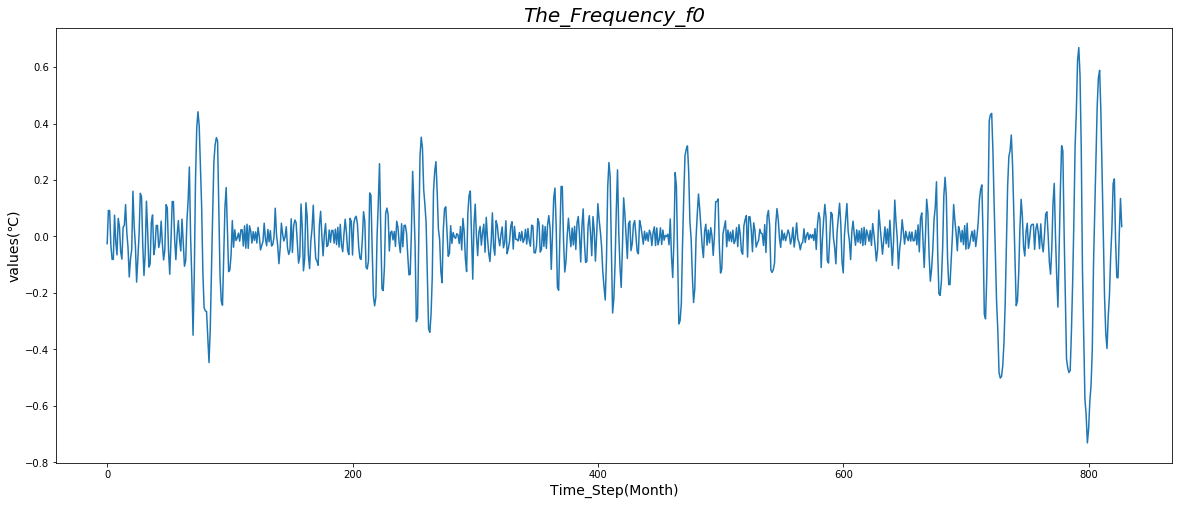

(1, 12, 1)
[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
(804, 12, 1)
(804, 12)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 12s - loss: 0.0207
Epoch 2/200
 - 4s - loss: 0.0204
Epoch 3/200
 - 3s - loss: 0.0194
Epoch 4/200
 - 3s - loss: 0.0186
Epoch 5/200
 - 3s - loss: 0.0185
Epoch 6/200
 - 3s - loss: 0.0182
Epoch 7/200
 - 3s - loss: 0.0175
Epoch 8/200
 - 3s - loss: 0.0179
Epoch 9/200
 - 3s - loss: 0.0174
Epoch 10/200
 - 3s - loss: 0.0175
Epoch 11/200
 - 3s - loss: 0.0175
Epoch 12/200
 - 3s - loss: 0.0175
Epoch 13/200
 - 3s - loss: 0.0176
Epoch 14/200
 - 3s - loss: 0.0169
Epoch 15/200
 - 4s - loss: 0.0175
Epoch 16/200
 - 3s - loss: 0.0171
Epoch 17/200
 - 5s - loss: 0.0178
Epoch 18/200
 - 4s - loss: 0

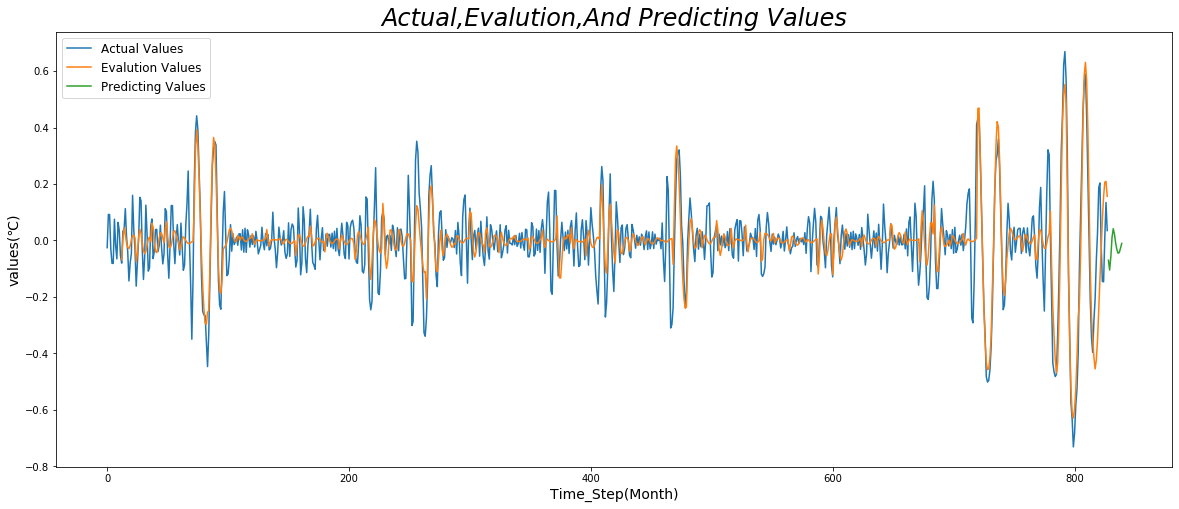

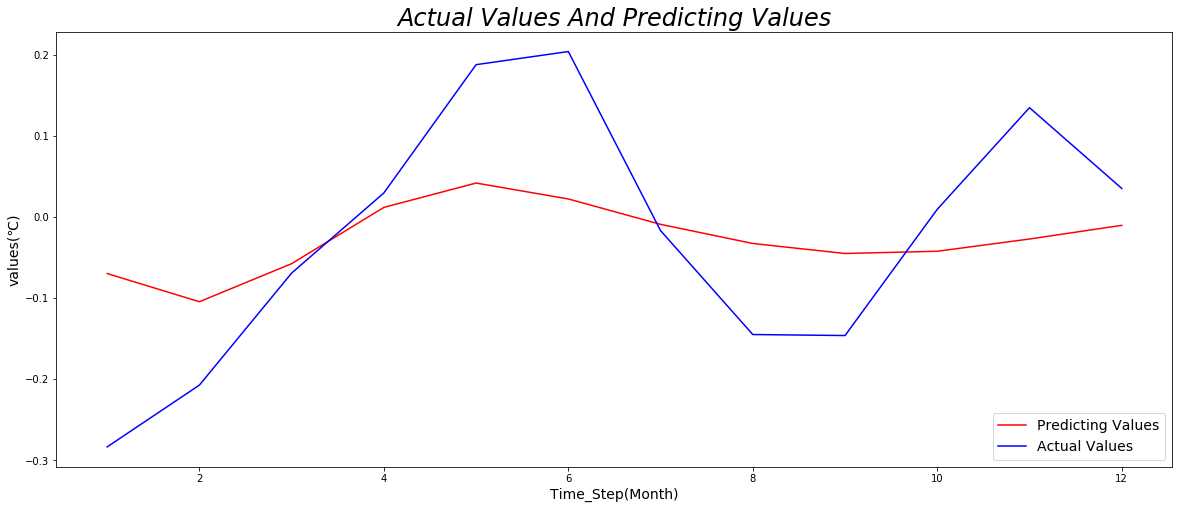

(828,)


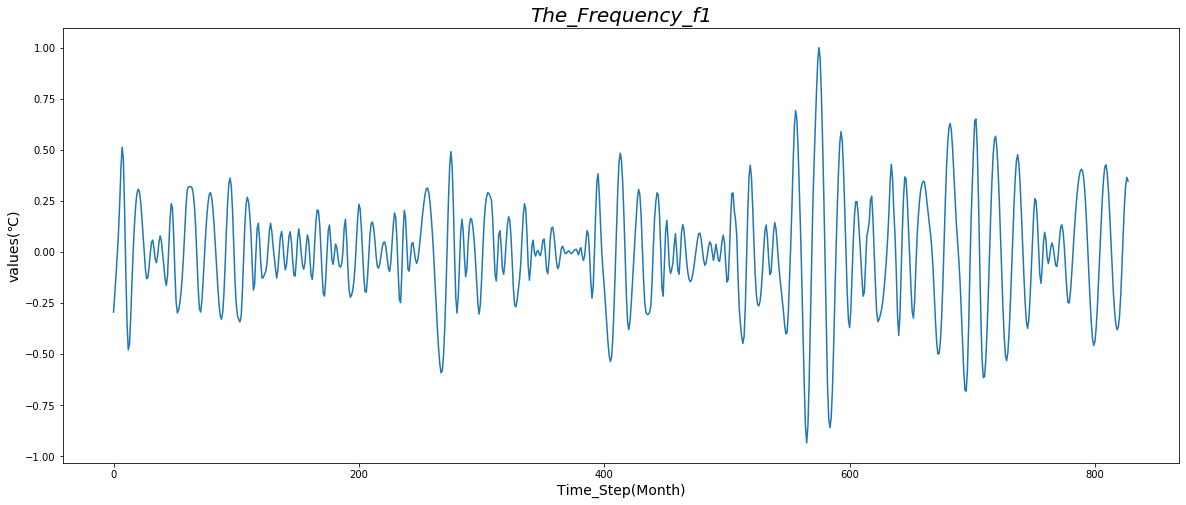

(1, 12, 1)
[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 14s - loss: 0.0567
Epoch 2/200
 - 5s - loss: 0.0476
Epoch 3/200
 - 5s - loss: 0.0442
Epoch 4/200
 - 4s - loss: 0.0402
Epoch 5/200
 - 4s - loss: 0.0392
Epoch 6/200
 - 4s - loss: 0.0405
Epoch 7/200
 - 4s - loss: 0.0366
Epoch 8/200
 - 5s - loss: 0.0372
Epoch 9/200
 - 4s - loss: 0.0354
Epoch 10/200
 - 4s - loss: 0.0347
Epoch 11/200
 - 4s - loss: 0.0343
Epoch 12/200
 - 4s - loss: 0.0343
Epoch 13/200
 - 4s - loss: 0.0346
Epoch 14/200
 - 6s - loss: 0.0335
Epoch 15/200
 - 4s - loss: 0.0335
Epoch 16/200
 - 5s - loss: 0.0332
Epoch 17/200
 - 4s - loss: 0.0335
Epoch 18/200
 - 4s - loss: 0.0336
Epoch 19/200
 - 4s - loss: 0.0324
Epoch 20/200
 - 4s - loss: 0.0324
Epoch 21/200
 - 4s - loss: 0.0314
Epoch 22/200
 - 4s - loss: 0.0316
Epoch 23/200
 - 4s - loss: 0.0333
Epoch 24/200
 - 4s - loss: 0.0336
Epoch 25/200
 - 4s - loss: 0.0319
E

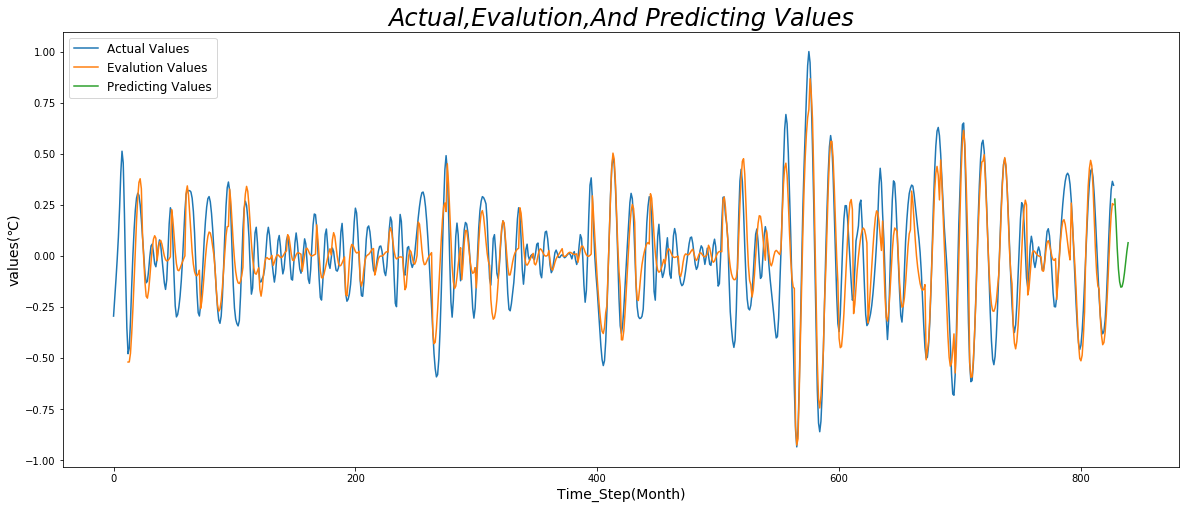

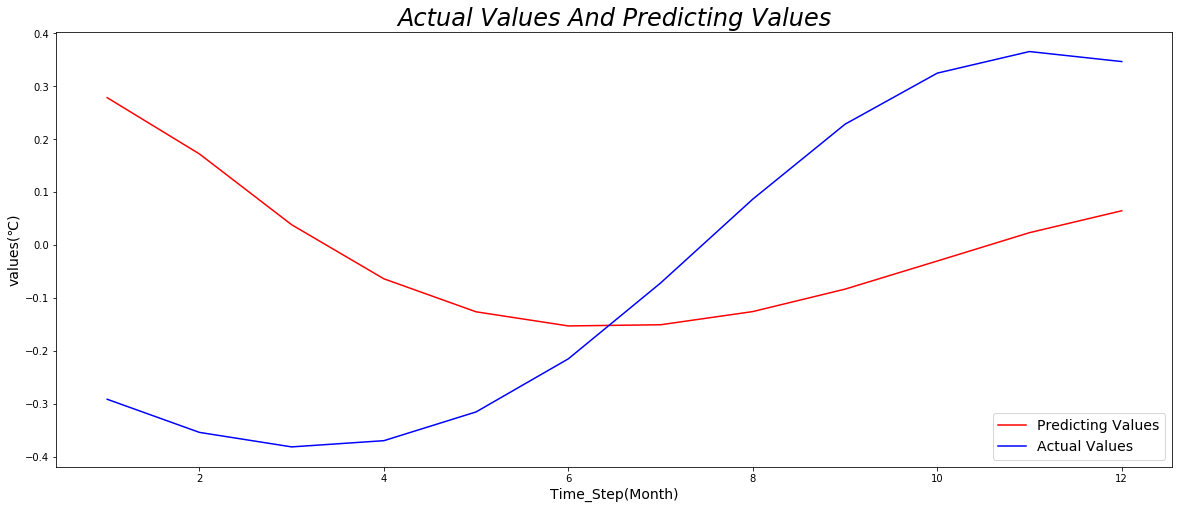

(828,)


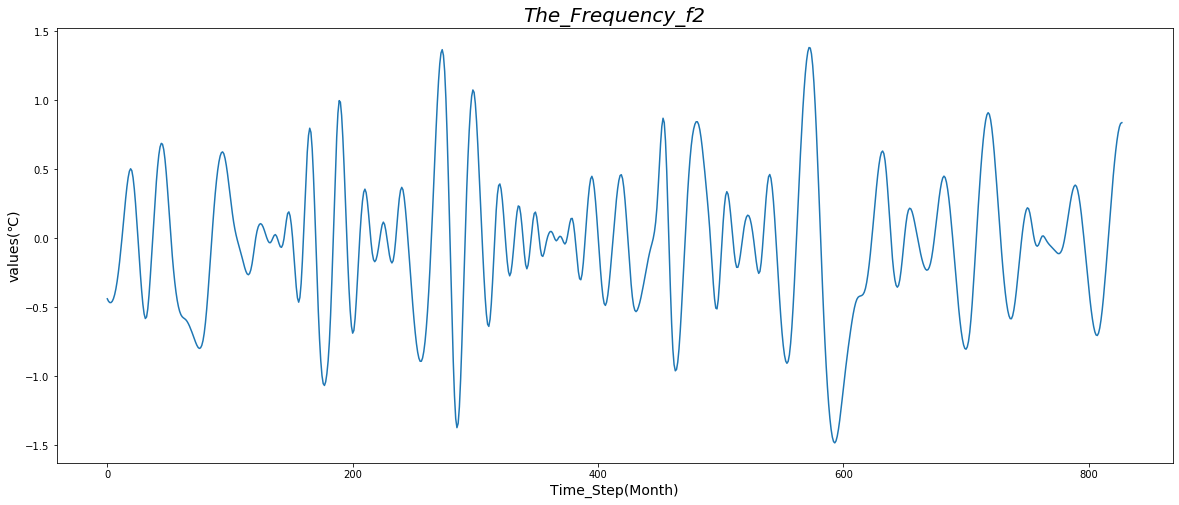

(1, 12, 1)
[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 9s - loss: 0.2306
Epoch 2/200
 - 3s - loss: 0.1805
Epoch 3/200
 - 3s - loss: 0.1609
Epoch 4/200
 - 4s - loss: 0.1428
Epoch 5/200
 - 4s - loss: 0.1371
Epoch 6/200
 - 4s - loss: 0.1322
Epoch 7/200
 - 3s - loss: 0.1389
Epoch 8/200
 - 3s - loss: 0.1315
Epoch 9/200
 - 3s - loss: 0.1241
Epoch 10/200
 - 3s - loss: 0.1085
Epoch 11/200
 - 3s - loss: 0.1249
Epoch 12/200
 - 3s - loss: 0.1172
Epoch 13/200
 - 3s - loss: 0.1075
Epoch 14/200
 - 3s - loss: 0.1066
Epoch 15/200
 - 3s - loss: 0.1221
Epoch 16/200
 - 3s - loss: 0.1101
Epoch 17/200
 - 3s - loss: 0.1019
Epoch 18/200
 - 3s - loss: 0.0974
Epoch 19/200
 - 4s - loss: 0.1008
Epoch 20/200
 - 3s - loss: 0.0965
Epoch 21/200
 - 4s - loss: 0.1001
Epoch 22/200
 - 3s - loss: 0.1042
Epoch 23/200
 - 4s - loss: 0.0913
Epoch 24/200
 - 4s - loss: 0.0918
Epoch 25/200
 - 4s - loss: 0.1003
Epoc

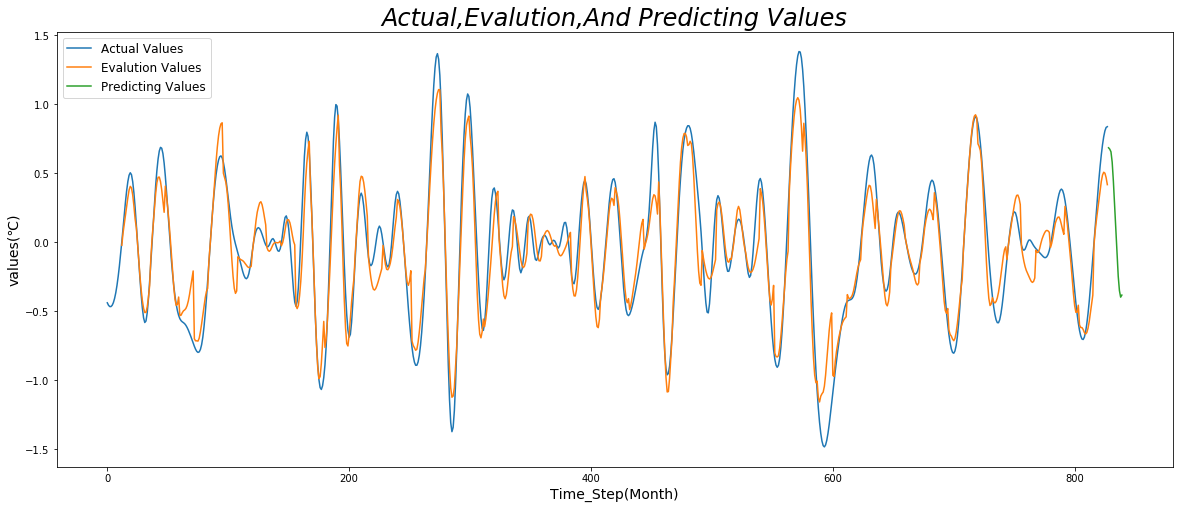

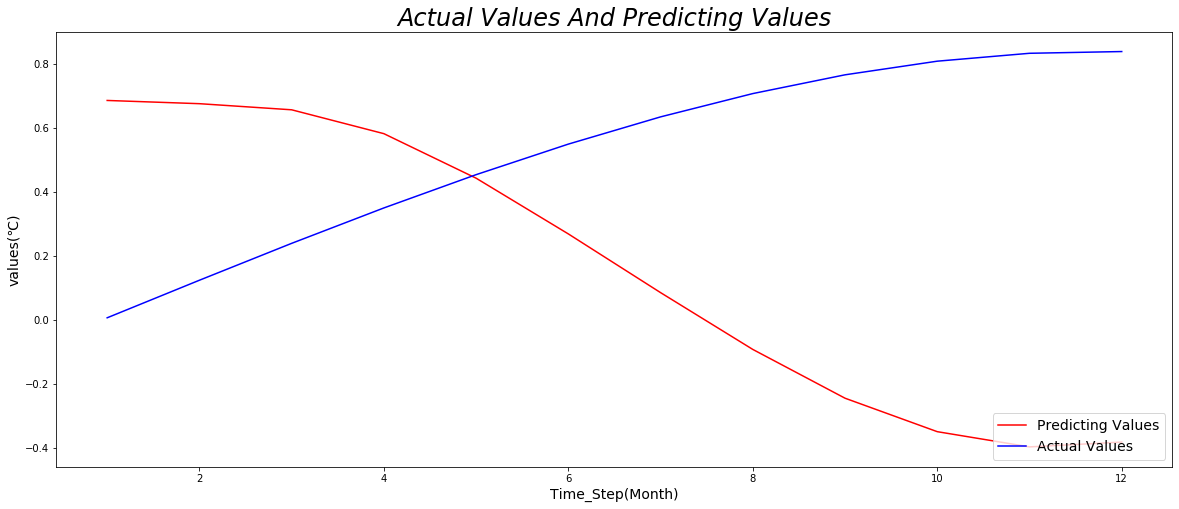

(828,)


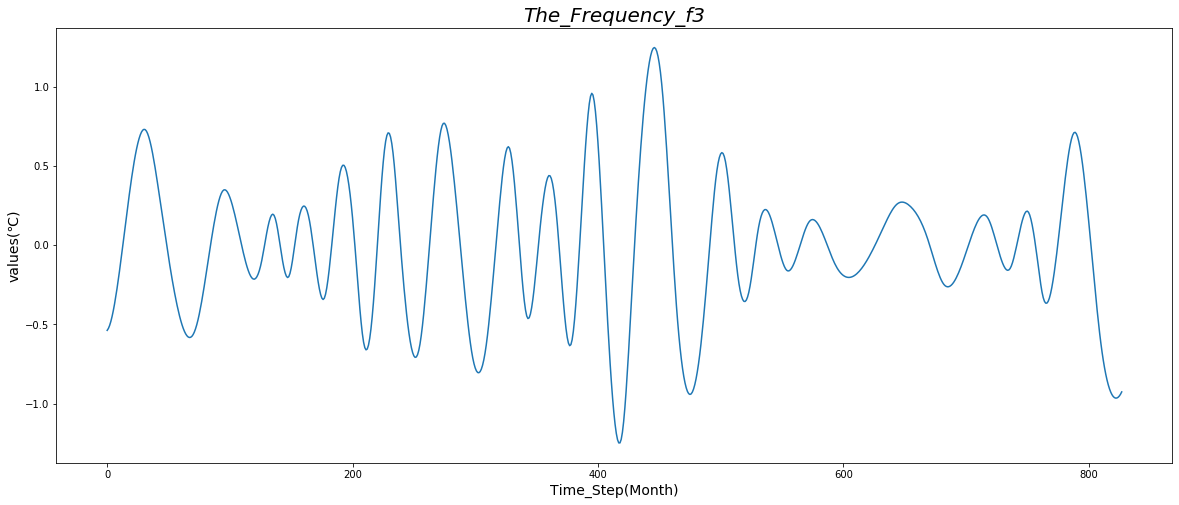

(1, 12, 1)
[-0.88131 -0.90671 -0.92735 -0.94342 -0.95507 -0.96249 -0.96584 -0.96529
 -0.96101 -0.95309 -0.94162 -0.92675]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 11s - loss: 0.1329
Epoch 2/200
 - 4s - loss: 0.0816
Epoch 3/200
 - 4s - loss: 0.0550
Epoch 4/200
 - 4s - loss: 0.0576
Epoch 5/200
 - 4s - loss: 0.0486
Epoch 6/200
 - 4s - loss: 0.0436
Epoch 7/200
 - 4s - loss: 0.0508
Epoch 8/200
 - 4s - loss: 0.0447
Epoch 9/200
 - 4s - loss: 0.0352
Epoch 10/200
 - 4s - loss: 0.0351
Epoch 11/200
 - 4s - loss: 0.0460
Epoch 12/200
 - 4s - loss: 0.0484
Epoch 13/200
 - 4s - loss: 0.0415
Epoch 14/200
 - 4s - loss: 0.0423
Epoch 15/200
 - 4s - loss: 0.0362
Epoch 16/200
 - 4s - loss: 0.0380
Epoch 17/200
 - 4s - loss: 0.0406
Epoch 18/200
 - 4s - loss: 0.0331
Epoch 19/200
 - 4s - loss: 0.0362
Epoch 20/200
 - 3s - loss: 0.0322
Epoch 21/200
 - 3s - loss: 0.0437
Epoch 22/200
 - 4s - loss: 0.0314
Epoch 23/200
 - 4s - loss: 0.0319
Epoch 24/200
 - 3s - loss: 0.0291
Epoch 25/200
 - 3s - loss: 0.0317
Epoch 26/200


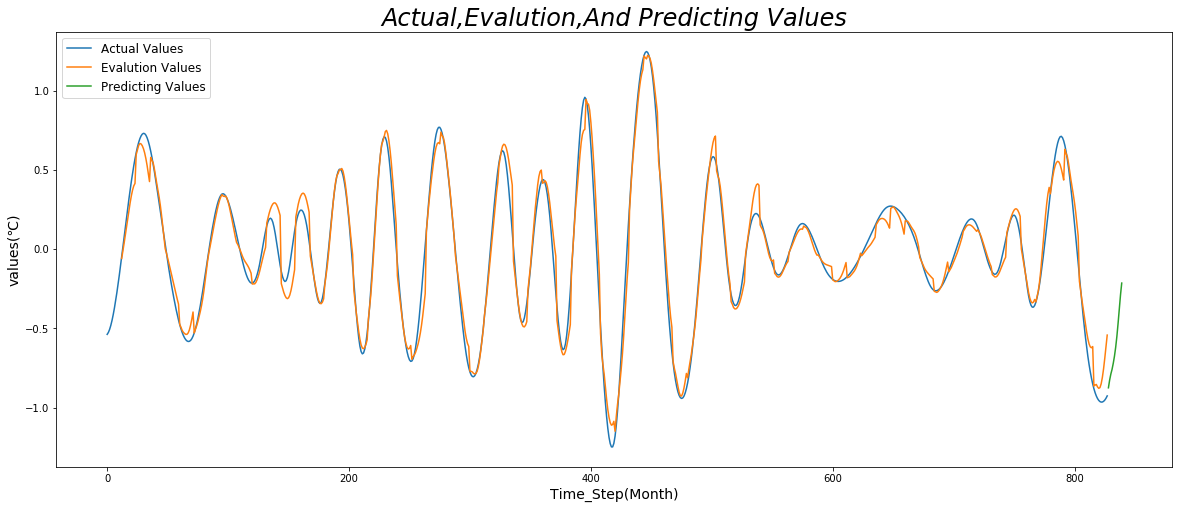

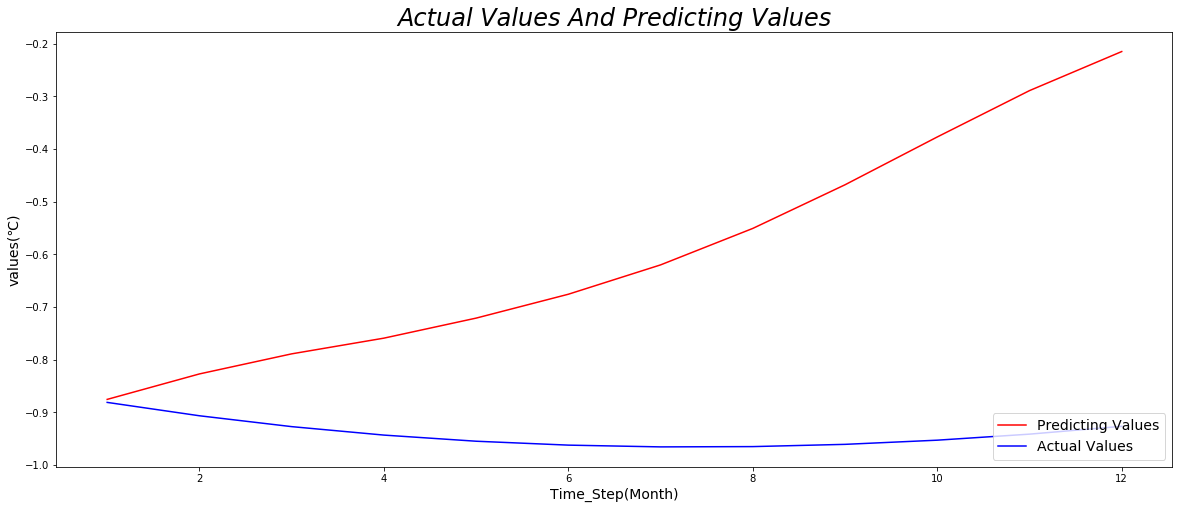

(828,)


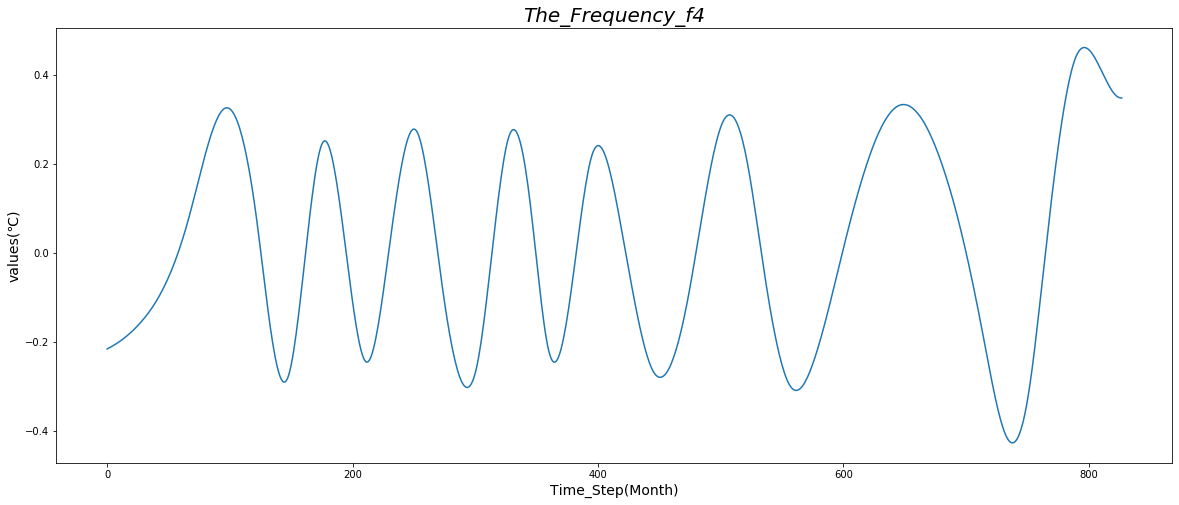

(1, 12, 1)
[0.37911 0.37411 0.36941 0.36506 0.36112 0.35764 0.35466 0.35226 0.35045
 0.34923 0.34856 0.34841]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 9s - loss: 0.0211
Epoch 2/200
 - 3s - loss: 0.0077
Epoch 3/200
 - 3s - loss: 0.0052
Epoch 4/200
 - 3s - loss: 0.0113
Epoch 5/200
 - 3s - loss: 0.0049
Epoch 6/200
 - 3s - loss: 0.0032
Epoch 7/200
 - 3s - loss: 0.0031
Epoch 8/200
 - 3s - loss: 0.0031
Epoch 9/200
 - 3s - loss: 0.0029
Epoch 10/200
 - 3s - loss: 0.0031
Epoch 11/200
 - 3s - loss: 0.0027
Epoch 12/200
 - 3s - loss: 0.0028
Epoch 13/200
 - 3s - loss: 0.0024
Epoch 14/200
 - 3s - loss: 0.0028
Epoch 15/200
 - 3s - loss: 0.0028
Epoch 16/200
 - 3s - loss: 0.0024
Epoch 17/200
 - 3s - loss: 0.0029
Epoch 18/200
 - 3s - loss: 0.0029
Epoch 19/200
 - 3s - loss: 0.0022
Epoch 20/200
 - 3s - loss: 0.0024
Epoch 21/200
 - 3s - loss: 0.0026
Epoch 22/200
 - 3s - loss: 0.0021
Epoch 23/200
 - 3s - loss: 0.0021
Epoch 24/200
 - 3s - loss: 0.0024
Epoch 25/200
 - 3s - loss: 0.0035
Epoch 26/200
 - 3s - loss:

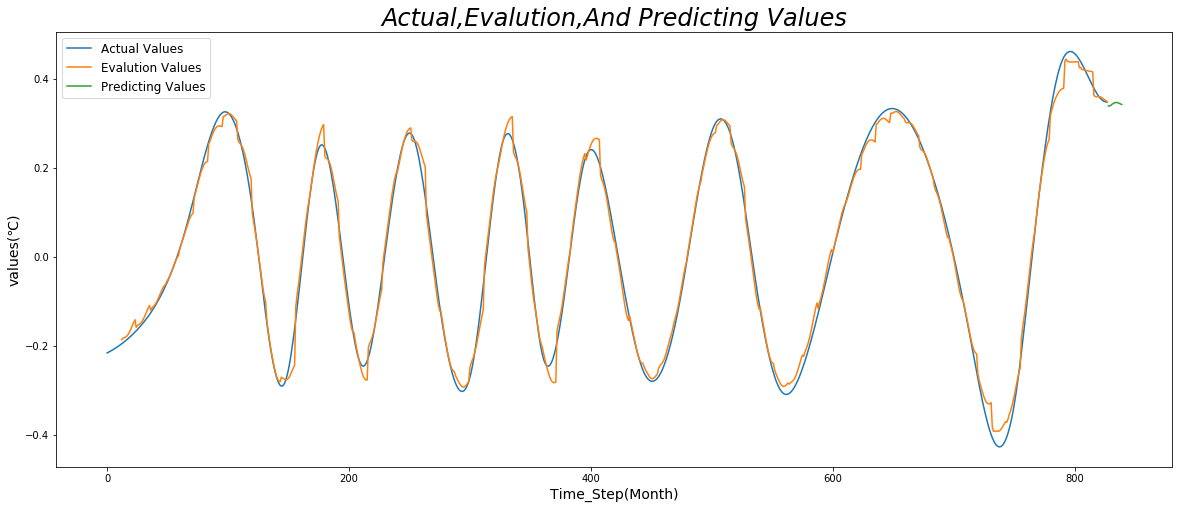

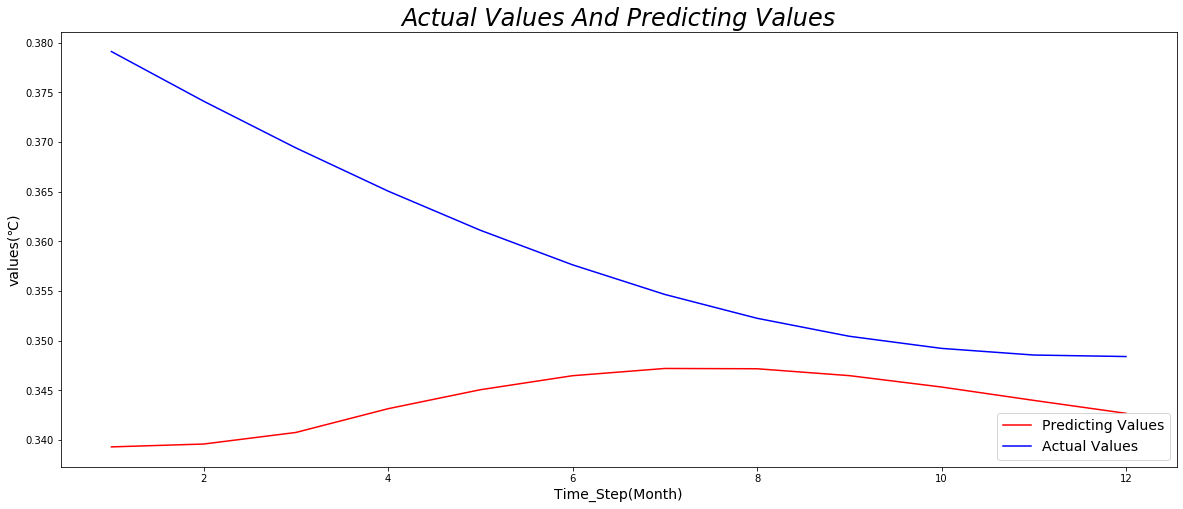

(828,)


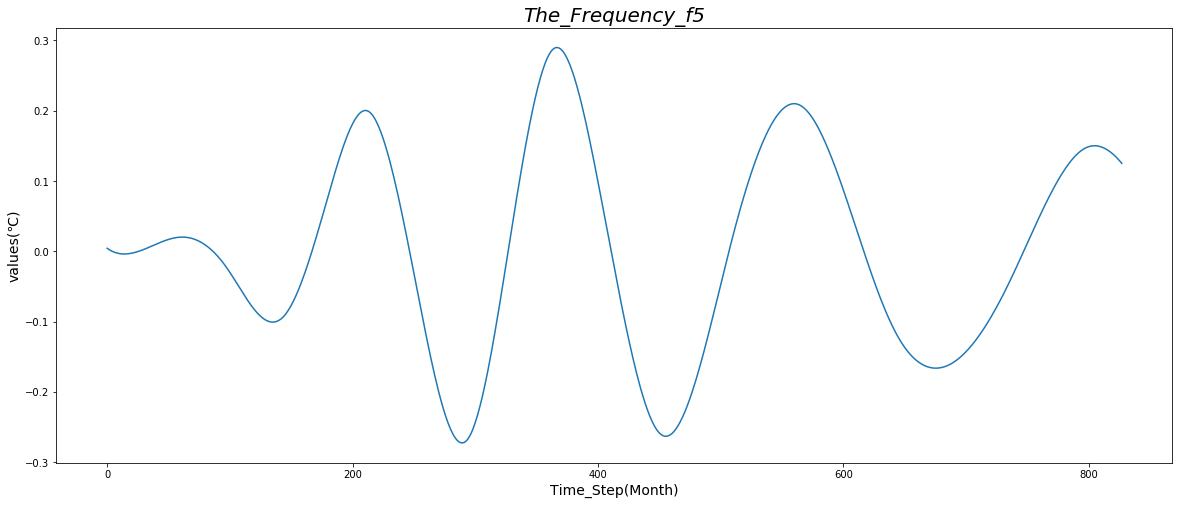

(1, 12, 1)
[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 11s - loss: 0.0068
Epoch 2/200
 - 3s - loss: 0.0034
Epoch 3/200
 - 3s - loss: 0.0018
Epoch 4/200
 - 3s - loss: 0.0014
Epoch 5/200
 - 5s - loss: 0.0010
Epoch 6/200
 - 7s - loss: 8.7646e-04
Epoch 7/200
 - 5s - loss: 7.3004e-04
Epoch 8/200
 - 4s - loss: 5.8786e-04
Epoch 9/200
 - 4s - loss: 5.6169e-04
Epoch 10/200
 - 7s - loss: 4.2806e-04
Epoch 11/200
 - 8s - loss: 6.9786e-04
Epoch 12/200
 - 6s - loss: 5.6420e-04
Epoch 13/200
 - 6s - loss: 5.1020e-04
Epoch 14/200
 - 6s - loss: 4.5658e-04
Epoch 15/200
 - 5s - loss: 4.6336e-04
Epoch 16/200
 - 6s - loss: 4.4843e-04
Epoch 17/200
 - 5s - loss: 4.8711e-04
Epoch 18/200
 - 5s - loss: 5.8099e-04
Epoch 19/200
 - 5s - loss: 4.1630e-04
Epoch 20/200
 - 5s - loss: 3.9778e-04
Epoch 21/200
 - 5s - loss: 3.4336e-04
Epoch 22/200
 - 5s - loss: 3.9054e-04
Epoch 23/200
 - 4s - loss: 3.7784e-04
Epoch 24/200
 - 5s - 

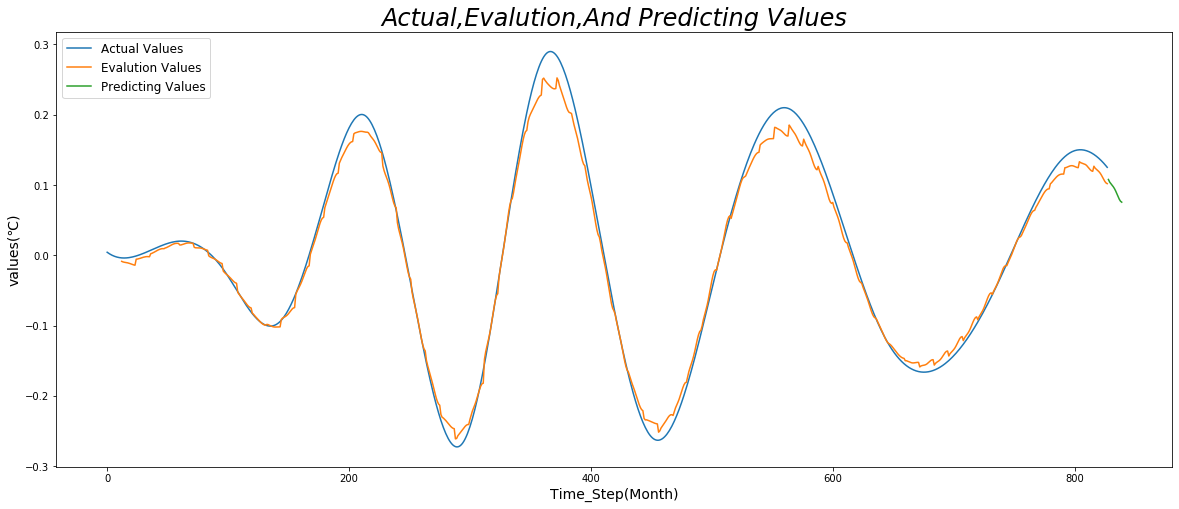

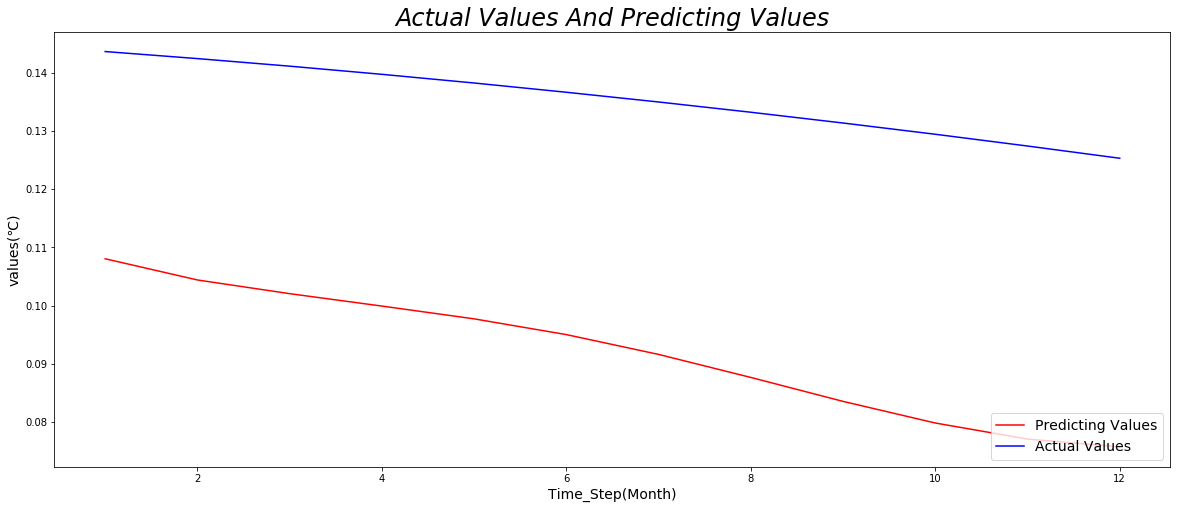

(828,)


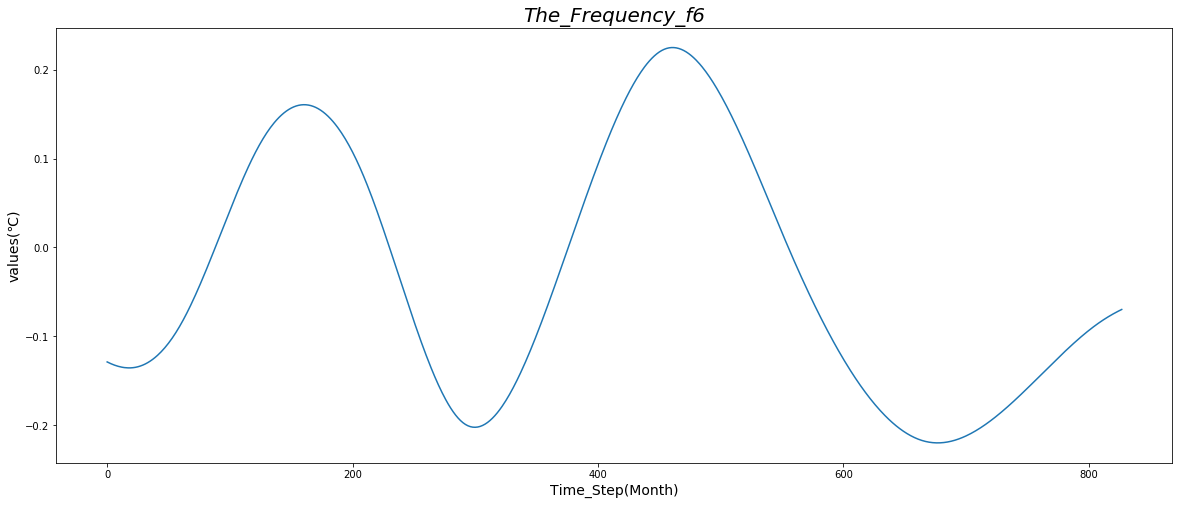

(1, 12, 1)
[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 14s - loss: 0.0040
Epoch 2/200
 - 4s - loss: 0.0014
Epoch 3/200
 - 4s - loss: 0.0014
Epoch 4/200
 - 4s - loss: 0.0010
Epoch 5/200
 - 4s - loss: 8.8594e-04
Epoch 6/200
 - 3s - loss: 9.0178e-04
Epoch 7/200
 - 4s - loss: 6.7873e-04
Epoch 8/200
 - 5s - loss: 6.1437e-04
Epoch 9/200
 - 4s - loss: 5.1834e-04
Epoch 10/200
 - 5s - loss: 6.6031e-04
Epoch 11/200
 - 4s - loss: 4.4952e-04
Epoch 12/200
 - 6s - loss: 4.6085e-04
Epoch 13/200
 - 6s - loss: 6.8128e-04
Epoch 14/200
 - 7s - loss: 5.9085e-04
Epoch 15/200
 - 5s - loss: 4.7271e-04
Epoch 16/200
 - 5s - loss: 4.4734e-04
Epoch 17/200
 - 4s - loss: 3.7367e-04
Epoch 18/200
 - 10s - loss: 8.0011e-04
Epoch 19/200
 - 11s - loss: 5.0501e-04
Epoch 20/200
 - 7s - loss: 4.0245e-04
Epoch 21/200
 - 6s - loss: 4.1408e-04
Epoch 22/200
 - 5s - loss: 3.7130e-04
Epoch 23/200
 - 5s - loss: 3.

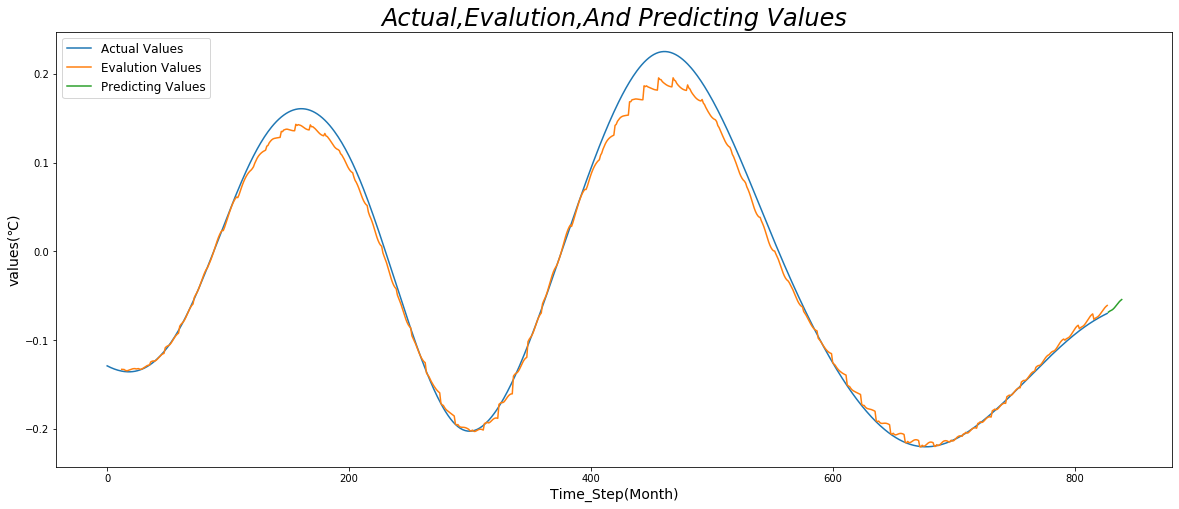

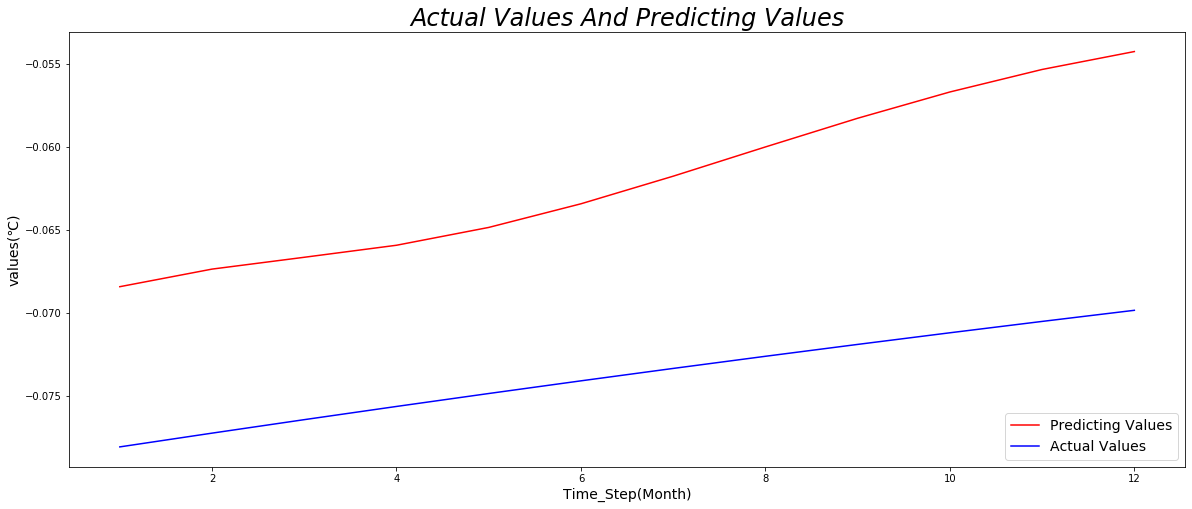

(828,)


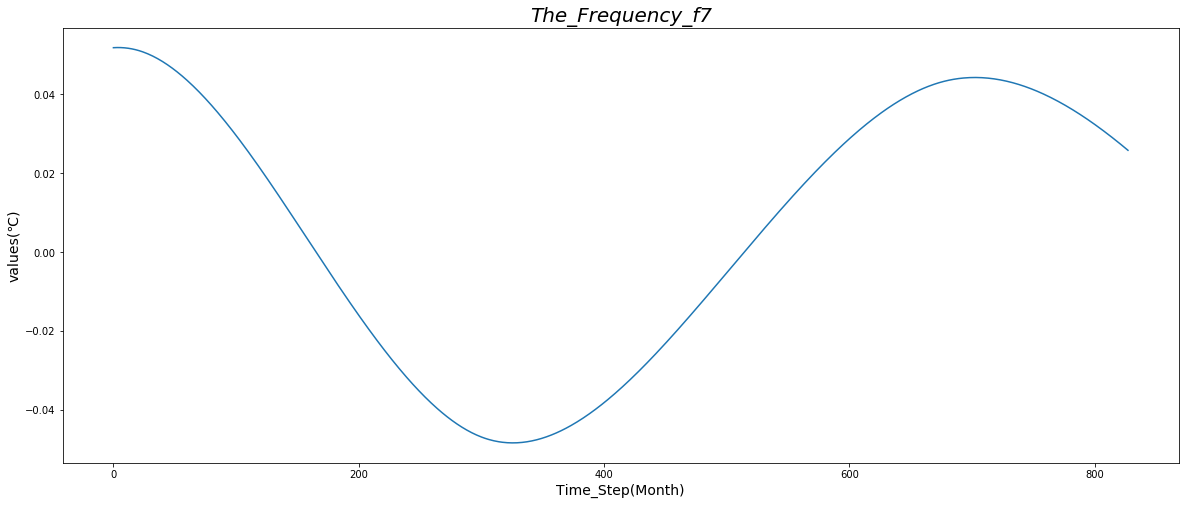

(1, 12, 1)
[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 12s - loss: 4.0496e-04
Epoch 2/200
 - 3s - loss: 8.6165e-05
Epoch 3/200
 - 3s - loss: 4.6682e-05
Epoch 4/200
 - 3s - loss: 3.5245e-05
Epoch 5/200
 - 3s - loss: 3.0987e-05
Epoch 6/200
 - 3s - loss: 3.6941e-05
Epoch 7/200
 - 3s - loss: 2.6479e-05
Epoch 8/200
 - 3s - loss: 2.3632e-05
Epoch 9/200
 - 4s - loss: 2.3606e-05
Epoch 10/200
 - 3s - loss: 2.9959e-05
Epoch 11/200
 - 5s - loss: 2.6053e-05
Epoch 12/200
 - 5s - loss: 2.4956e-05
Epoch 13/200
 - 7s - loss: 3.3518e-05
Epoch 14/200
 - 5s - loss: 2.5764e-05
Epoch 15/200
 - 4s - loss: 2.5915e-05
Epoch 16/200
 - 5s - loss: 2.7093e-05
Epoch 17/200
 - 7s - loss: 2.6776e-05
Epoch 18/200
 - 6s - loss: 2.1228e-05
Epoch 19/200
 - 5s - loss: 3.8807e-05
Epoch 20/200
 - 5s - loss: 6.3635e-05
Epoch 21/200
 - 5s - loss: 3.3803e-05
Epoch 22/200
 - 5s - loss: 2.9945e-05
Epoch 23/200
 - 4s - loss: 

[0.02194398 0.02177322 0.02165125 0.02153752 0.02143659 0.02135279
 0.02128744 0.02123935 0.02120597 0.02118423 0.02117115 0.02116418]
(840,)
(69, 12, 1)


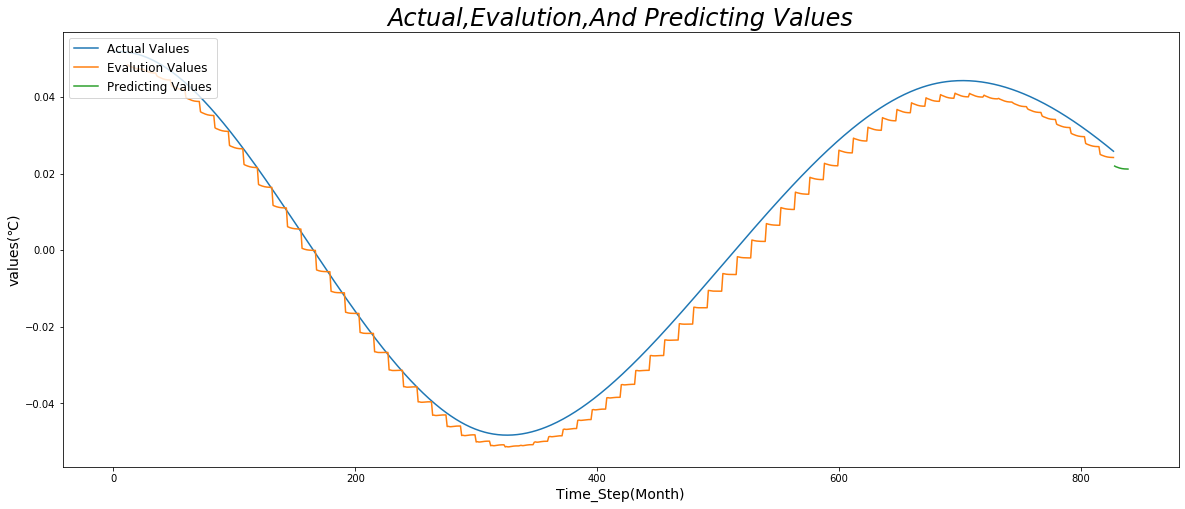

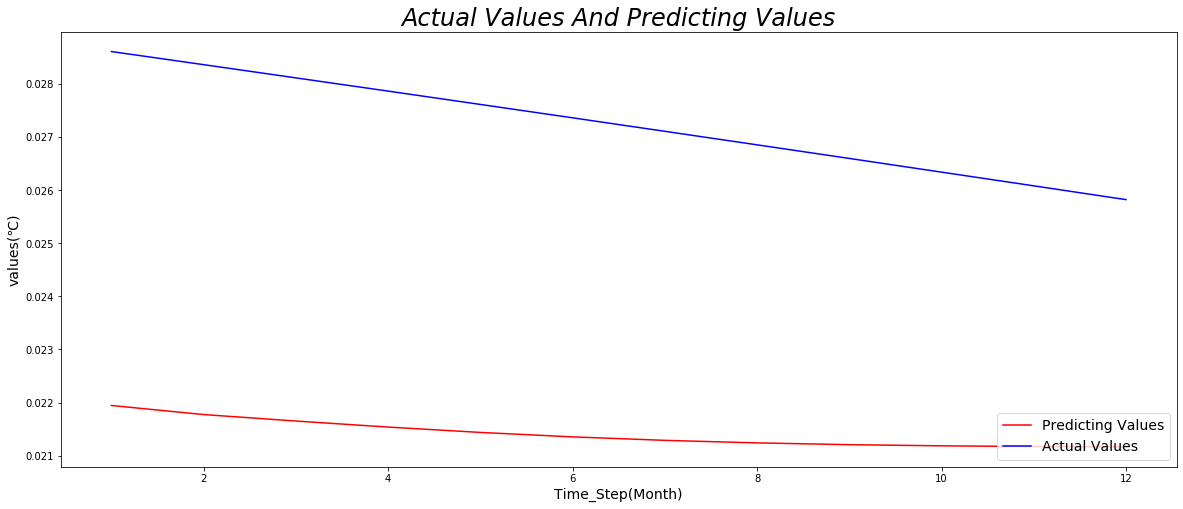

(828,)


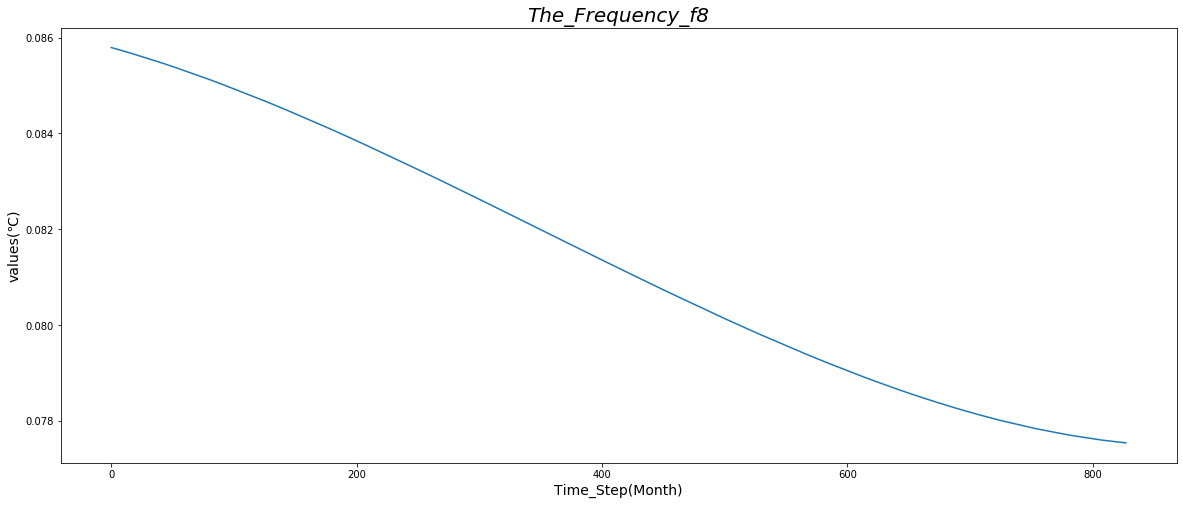

(1, 12, 1)
[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 20s - loss: 5.4344e-04
Epoch 2/200
 - 6s - loss: 1.4453e-05
Epoch 3/200
 - 5s - loss: 7.8080e-06
Epoch 4/200
 - 5s - loss: 7.2279e-06
Epoch 5/200
 - 5s - loss: 7.1210e-06
Epoch 6/200
 - 5s - loss: 6.8217e-06
Epoch 7/200
 - 5s - loss: 6.9374e-06
Epoch 8/200
 - 5s - loss: 7.1517e-06
Epoch 9/200
 - 6s - loss: 6.8333e-06
Epoch 10/200
 - 5s - loss: 7.2959e-06
Epoch 11/200
 - 5s - loss: 7.4009e-06
Epoch 12/200
 - 4s - loss: 6.8127e-06
Epoch 13/200
 - 5s - loss: 6.7288e-06
Epoch 14/200
 - 5s - loss: 6.6490e-06
Epoch 15/200
 - 5s - loss: 7.4840e-06
Epoch 16/200
 - 5s - loss: 6.9920e-06
Epoch 17/200
 - 6s - loss: 6.7129e-06
Epoch 18/200
 - 6s - loss: 6.6125e-06
Epoch 19/200
 - 5s - loss: 6.4330e-06
Epoch 20/200
 - 4s - loss: 6.4129e-06
Epoch 21/200
 - 5s - loss: 6.9992e-06
Epoch 22/200
 - 5s - loss: 6.9534e-06
Epoch 23/200
 - 5s - loss: 

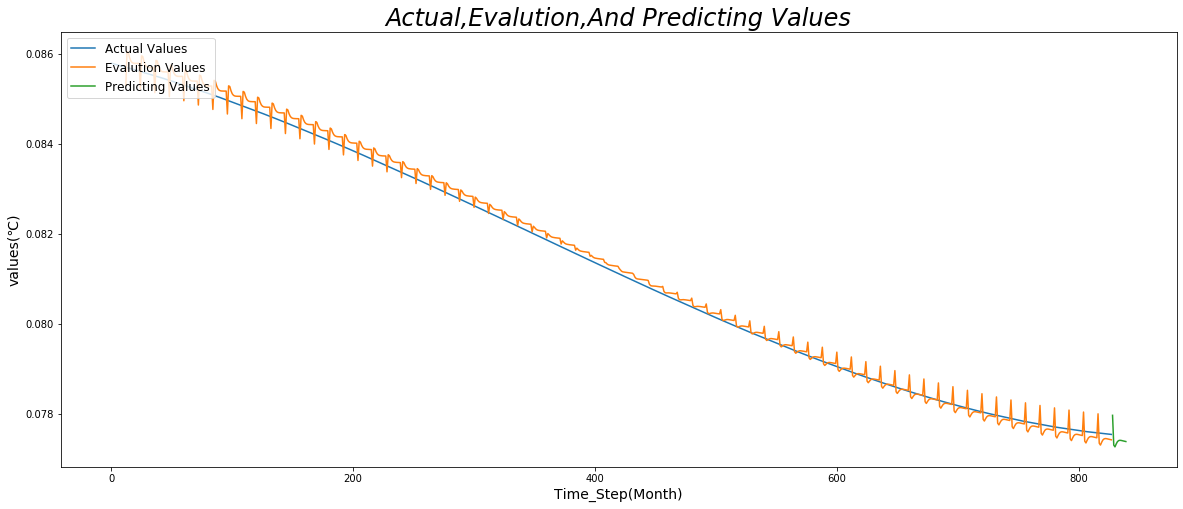

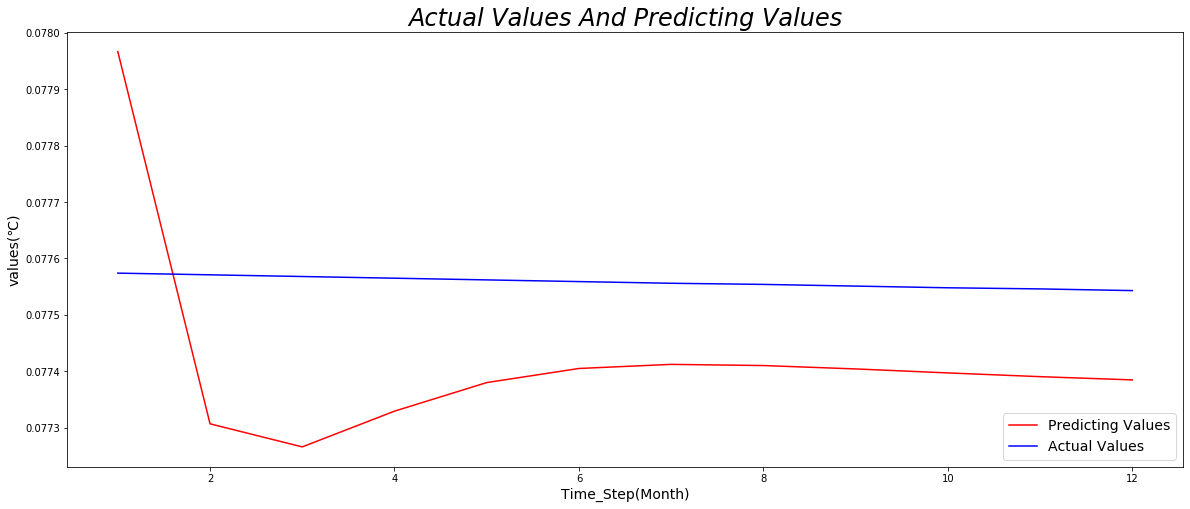

In [5]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]

signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_SoloLstm_EMD_prediction')==False):
    os.makedirs('12_months_SoloLstm_EMD_prediction')
        
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_SoloLstm_EMD_prediction/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (test.shape)
    print (test[0].reshape(-1))
    
    n_input = 12
    n_out=12
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    print (train_y.shape)
    
    model=build_model(train_x,train_y,n_input,n_out)
    score, scores,predictions = evaluate_model(train, test, n_input)
    trainPredict = model.predict(train)
    print (predictions.reshape(-1))
    
 
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)[0:-12]

# shift test predictions for plotting
    testPredictPlot = np.zeros(840)
    print (testPredictPlot.shape)
    print (trainPredict.shape)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1)):len(testPredictPlot)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [6]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07796717]
 [0.07730662]
 [0.07726568]
 [0.07732908]
 [0.07737979]
 [0.07740482]
 [0.07741211]
 [0.07741002]
 [0.077404  ]
 [0.07739694]
 [0.07739028]
 [0.07738455]]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.1

In [7]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
-----------------------------------
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
-----------------------------------
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70

In [19]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(np.array(prediction_in_one[i]).reshape(-1)))
   
    predicted_values = np.add(predicted_values, np.array(prediction_in_one[i]).reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.06998097 -0.10468245 -0.05777218  0.0116559   0.0416544   0.02202732
 -0.00927833 -0.03287523 -0.04521439 -0.04245231 -0.02736184 -0.01049909]
[-0.06998097 -0.10468245 -0.05777218  0.0116559   0.0416544   0.02202732
 -0.00927833 -0.03287523 -0.04521439 -0.04245231 -0.02736184 -0.01049909]
the 1 frequence:
predicted_value:[ 0.27826804  0.17200243  0.03824725 -0.0638969  -0.1262519  -0.15291409
 -0.15070261 -0.12580751 -0.08342807 -0.03029896  0.02324108  0.06461097]
[ 0.20828707  0.06731998 -0.01952493 -0.052241   -0.08459751 -0.13088677
 -0.15998095 -0.15868274 -0.12864246 -0.07275126 -0.00412076  0.05411187]
the 2 frequence:
predicted_value:[ 0.6851513   0.6750504   0.65594774  0.58131903  0.44212675  0.26787263
  0.08434747 -0.09326382 -0.24576724 -0.35039753 -0.39799273 -0.38296342]
[ 0.89343835  0.74237036  0.63642281  0.52907804  0.35752924  0.13698586
 -0.07563347 -0.25194656 -0.3744097  -0.42314879 -0.402

[[-0.9]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.1]
 [ 0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [ 0.7]
 [ 0.9]
 [ 0.8]]
[ 0.49664097  0.39082556  0.32237265  0.24579028  0.11304352 -0.06206368
 -0.22000969 -0.32929522 -0.3719657  -0.33318857 -0.22688565 -0.0809826 ]


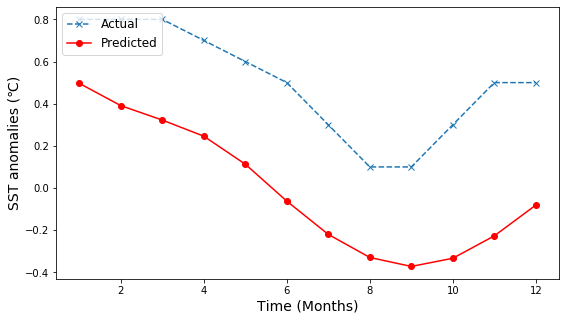

In [20]:
print (round_true_values)
print (predicted_values)

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)

actual_values_2019=[0.8,0.8,0.8,0.7,0.6,0.5,0.3,0.1,0.1,0.3,0.5,0.5]
plt.plot(index_start,np.array(actual_values_2019).reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_the_final_predict_real_result.png')
plt.show() 
 